# Import Libraries

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

# Data Analyisis and Visualization

In [9]:
df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/butterfly-image-classification/Training_set.csv'

In [10]:
df = pd.read_csv("Training_set.csv")
df.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


In [11]:
len(df)

6499

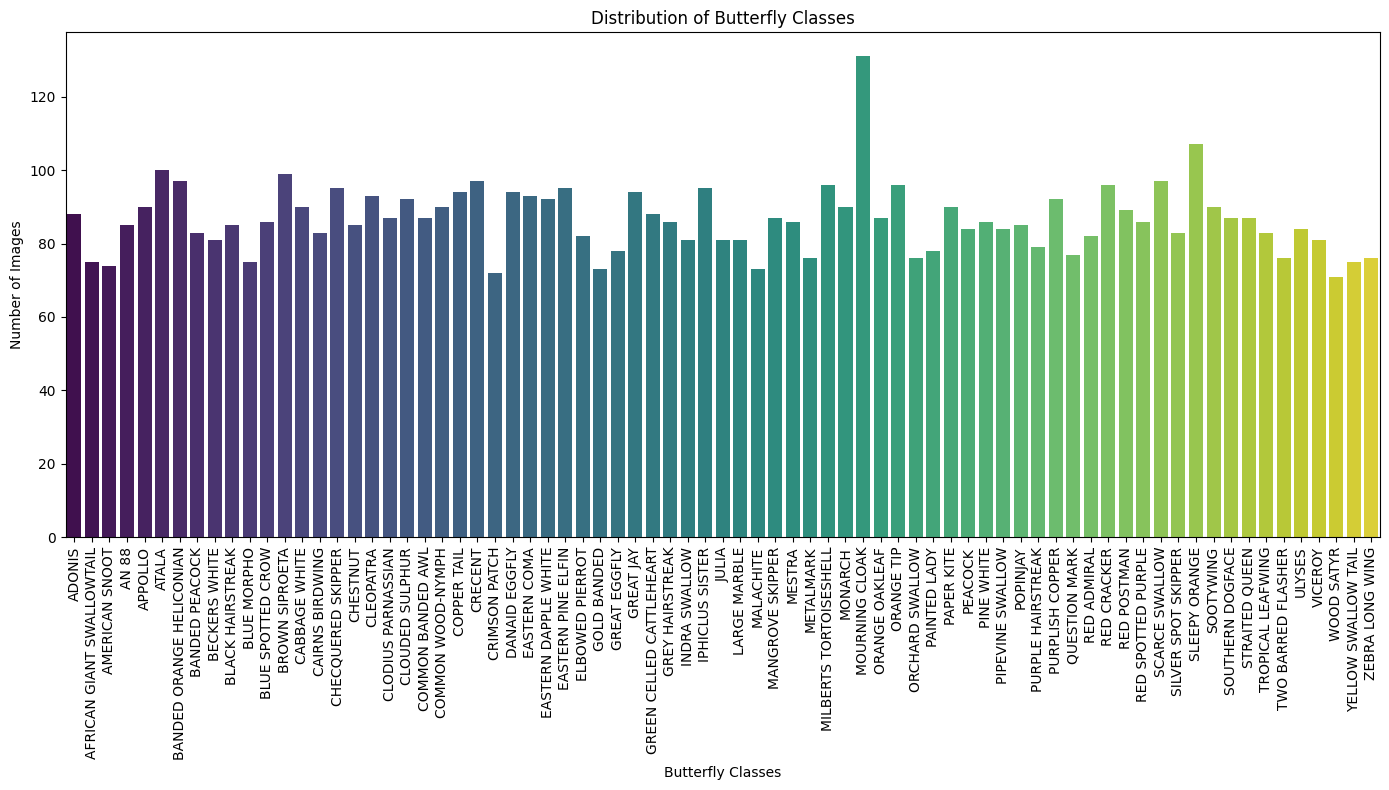

In [15]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14,8))
sns.barplot(x=class_counts.index,y=class_counts.values,palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

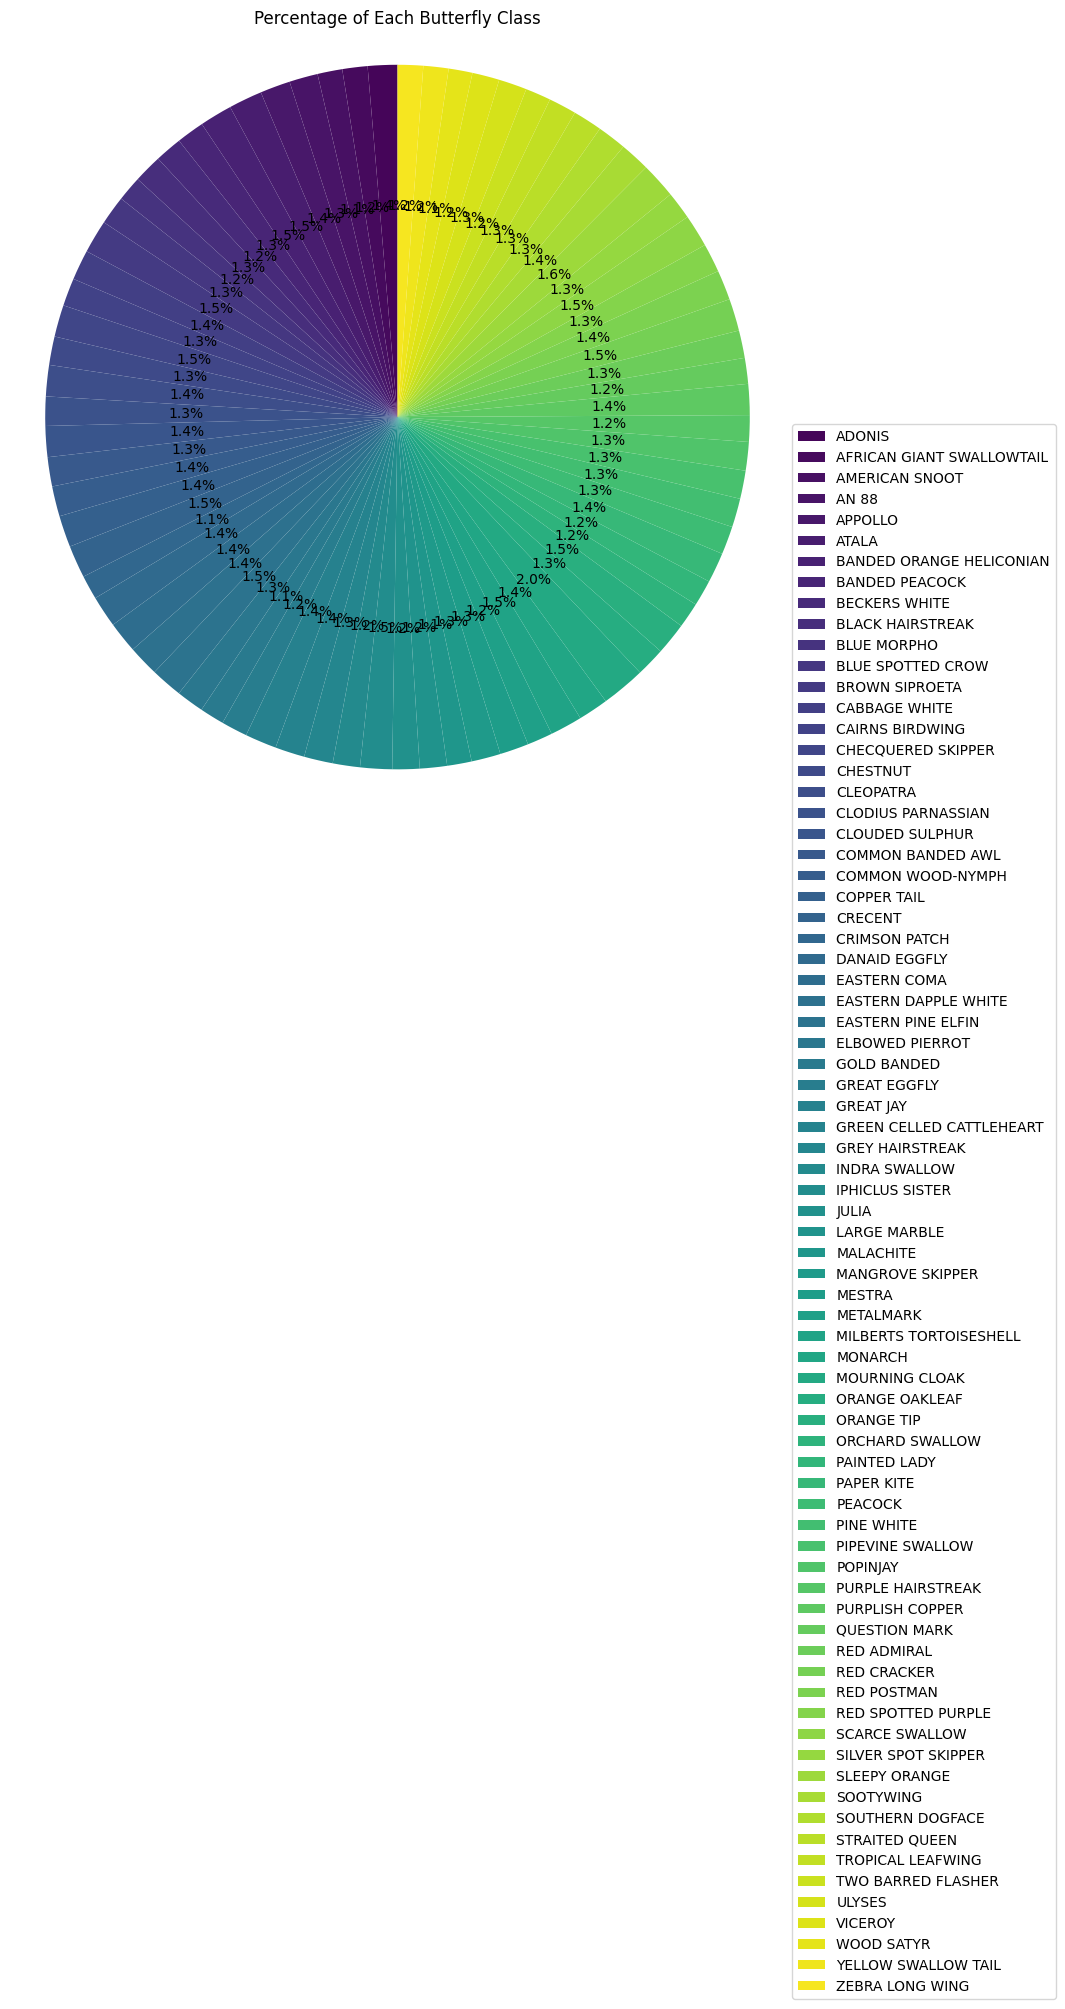

In [19]:
colors = sns.color_palette("viridis",len(class_counts))
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(10,10))
plt.pie(class_counts.values,labels=None,autopct='%1.1f%%',startangle=90,colors=colors)
plt.title('Percentage of Each Butterfly Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

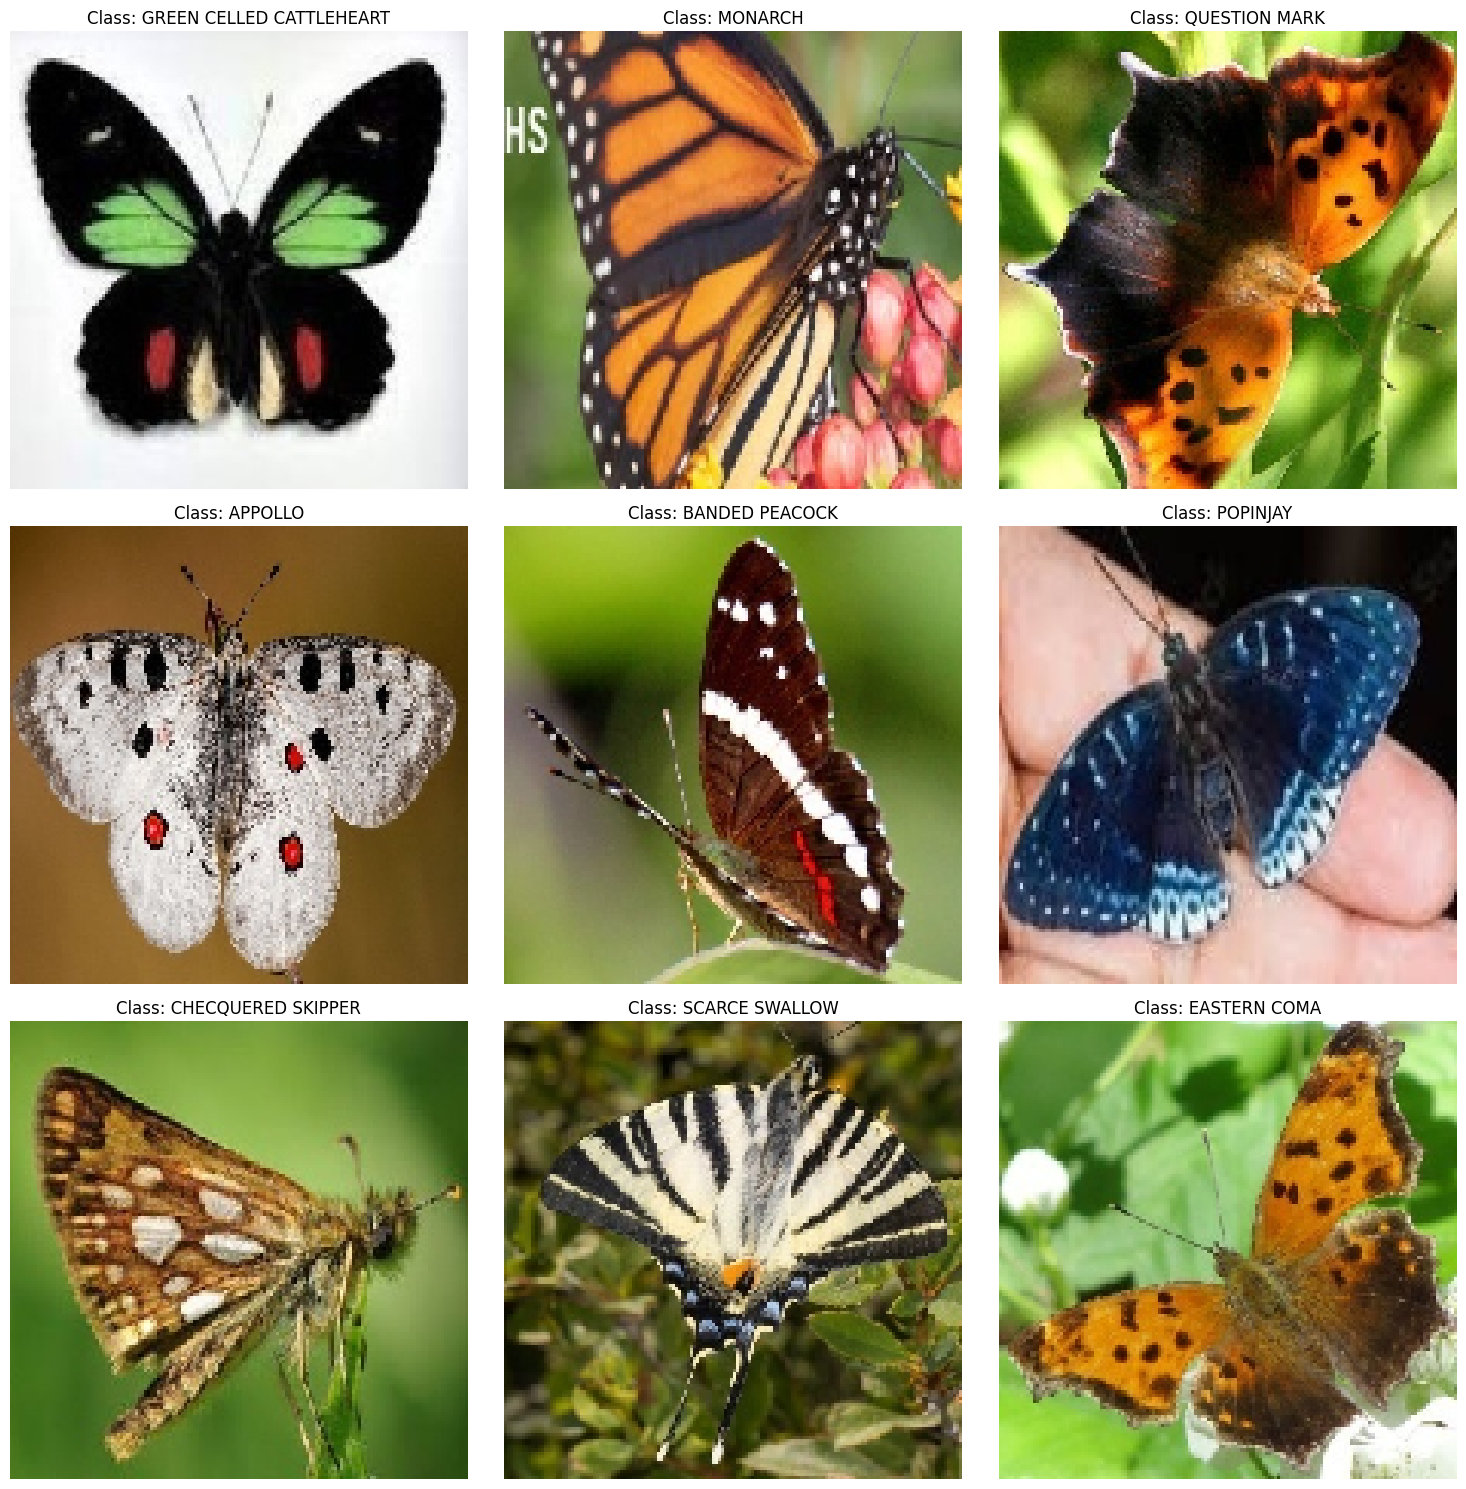

In [22]:
image_dir = "train"

sample_images = df.sample(9,random_state=42)

fig, axes = plt.subplots(3,3,figsize=(15,15))

for i,(index,row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir,row['filename'])
    img = load_img(img_path,target_size=(150,150))
    img_array = img_to_array(img)/255.0 # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Splitting Dataset

In [23]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=42)
image_dir = "train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


# Building the Model 

In [24]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [25]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40
162/162 [==============================] - 469s 3s/step - loss: 3.9135 - accuracy: 0.0666 - val_loss: 3.4407 - val_accuracy: 0.1422
Epoch 2/40
162/162 [==============================] - 268s 2s/step - loss: 2.9562 - accuracy: 0.2177 - val_loss: 2.3972 - val_accuracy: 0.3422
Epoch 3/40
162/162 [==============================] - 267s 2s/step - loss: 2.4222 - accuracy: 0.3478 - val_loss: 1.9210 - val_accuracy: 0.4664
Epoch 4/40
162/162 [==============================] - 246s 2s/step - loss: 2.0605 - accuracy: 0.4202 - val_loss: 1.6833 - val_accuracy: 0.5266
Epoch 5/40
162/162 [==============================] - 192s 1s/step - loss: 1.8678 - accuracy: 0.4697 - val_loss: 1.5799 - val_accuracy: 0.5547
Epoch 6/40
162/162 [==============================] - 191s 1s/step - loss: 1.6824 - accuracy: 0.5218 - val_loss: 1.5323 - val_accuracy: 0.5719
Epoch 7/40
162/162 [==============================] - 187s 1s/step - loss: 1.5809 - accuracy: 0.5421 - val_loss: 1.5292 - val_accuracy: 0.5766

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad defined at (most recent call last):
  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code

  File "C:\Users\georg\AppData\Local\Temp\ipykernel_2668\713760683.py", line 1, in <module>

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1130, in train_step

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\optimizer.py", line 543, in minimize

  File "C:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[32,148,148,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1493]

# Evaluating the Model

NameError: name 'history' is not defined

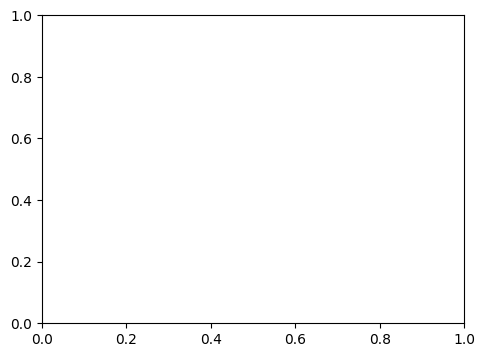

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
display_images(val_images, true_labels, pred_labels, class_names, num_images=9)